# Installing dependencies

In [ ]:
!pip install geopandas
!pip install sentinelhub
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 106.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.4/244.4 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 30.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.8 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=fa181af895b38499d334cb3dc120fed4e148b31f30aef9aeabf3b5e177d5019d
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.5 MB/s eta 0:00:00


# Specifying file tree

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/diploma/sentinel_2_dataset.h5 ./

In [ ]:
!cp /content/drive/MyDrive/diploma/germ_crop_mask.npy ./

In [ ]:
!cp /content/drive/MyDrive/diploma/afro_crop_mask.npy ./

In [ ]:
!cp /content/drive/MyDrive/diploma/germany_sentinel2_data/dlr_fusion_competition_germany_train_source_sentinel_2/dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/clp.npy ./

In [ ]:
!cp /content/drive/MyDrive/diploma/germany_sentinel2_data/dlr_fusion_competition_germany_train_source_sentinel_2/dlr_fusion_competition_germany_train_source_sentinel_2_33N_18E_242N_2018/bbox.pkl ./

In [ ]:
!cp /content/drive/MyDrive/diploma/germany_sentinel2_data/dlr_fusion_competition_germany_train_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson ./

In [ ]:
bands_path = 'sentinel_2_dataset.h5'
germ_mask_path = 'germ_crop_mask.npy'
afro_mask_path = 'afro_crop_mask.npy'
cloud_prob_path = 'clp.npy'
labels_path = 'labels.geojson'

# Defining Keras Data Sequence

In [ ]:
from tensorflow import keras
import math
from random import shuffle, seed
import pickle
import geopandas as gpd
import numpy as np
import rasterio as rio
from rasterio import features
import h5py
import os

CLASSES = ["Wheat", "Rye", "Barley", "Oats", "Corn", "Oil Seeds", "Root Crops", "Meadows", "Forage Crops", "Canola", "Lucerne", "Small grain grazing"]
CROP_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
min_area=1000

hf = h5py.File(bands_path,'r')
bands = hf['sentinel2_data']

germ_mask = np.load(germ_mask_path)
afro_mask = np.load(afro_mask_path)

temporal_length, width, height, bands_count = bands.shape

print(bands.shape)


with open(os.path.join("bbox.pkl"), 'rb') as f:
    bbox = pickle.load(f)
    crs = str(bbox.crs)
    minx, miny, maxx, maxy = bbox.min_x, bbox.min_y, bbox.max_x, bbox.max_y

labels = gpd.read_file(labels_path)
labels = labels.to_crs(crs)

mask = labels.geometry.area > min_area
print(f"ignoring {(~mask).sum()}/{len(mask)} fields with area < {min_area}m2")
labels = labels.loc[mask]

clp = np.load("clp.npy", mmap_mode='r')

transform = rio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

crop_mask = features.rasterize(
    zip(labels.geometry, labels.crop_id), all_touched=True,
    transform=transform, out_shape=(width, height)
).astype('uint8')

(220, 2400, 2400, 12)
ignoring 30/2534 fields with area < 1000m2


In [ ]:
temporal_length = 144

In [ ]:
import tensorflow as tf

class Sentinel2Data(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, img_size, batch_size, bands, germ_mask, afro_mask, indexes, germ_temporal_ending=144, required_bands=[1, 4, 5]):
        self.image_size = img_size
        self.batch_size = batch_size
        self.bands = bands
        self.germ_mask = germ_mask
        self.afro_mask = afro_mask
        self.germ_temporal_ending = germ_temporal_ending
        self.required_bands = required_bands
        self.indexes = indexes
    
    def on_epoch_end(self):
        shuffle(self.indexes)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        idx_start = idx * self.batch_size
        idx_end = idx_start + self.batch_size
        if idx_end > len(self)*self.batch_size:
          idx_end = len(self)*self.batch_size
          idx_start = idx_end-self.batch_size

        batch_idxs = self.indexes[idx_start:idx_end]

        x = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1], len(self.required_bands)), dtype='float32')
        y = np.zeros(shape=(len(batch_idxs), self.image_size[0], self.image_size[1]), dtype='uint8')

        for i in range(len(batch_idxs)):
            temporal_i, row_bounds, col_bounds = batch_idxs[i]
            for j in range(len(self.required_bands)):
                band_j = self.required_bands[j]
                x[i, ..., j] = self.bands[temporal_i, row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1], band_j] / 21412.0
            y[i] = self.germ_mask[row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1]] if temporal_i < self.germ_temporal_ending else self.afro_mask[row_bounds[0]:row_bounds[1], col_bounds[0] : col_bounds[1]]

        return x, tf.one_hot(y, len(CLASSES)+1, axis=-1)

In [ ]:
sample_shape=(128,128)

samples_in_row = math.ceil(width / sample_shape[0])
samples_in_col = math.ceil(height / sample_shape[1])

indexes = []
for temporal_index in range(temporal_length):
    for y_i in range(samples_in_col):
        col_start = y_i * sample_shape[1]
        col_end = col_start + sample_shape[1]

        if col_end > height:
            col_start = width - sample_shape[1]
            col_end = height

        for x_i in range(samples_in_row):
            row_start = x_i * sample_shape[0]
            row_end = row_start + sample_shape[0]

            if row_end > width:
                row_start = width - sample_shape[0]
                row_end = width

            mean_clp = np.mean(clp[temporal_index, row_start:row_end, col_start : col_end, 0] / 255.)
            if mean_clp < 0.4:
                indexes.append((temporal_index, (row_start, row_end), (col_start, col_end)))

seed(2023)
shuffle(indexes)

In [ ]:
train_batch_size = 16
val_batch_size = train_batch_size

In [ ]:
validation_split=0.7
split_index = math.ceil(len(indexes) * validation_split)
train_seq = Sentinel2Data(
    img_size=sample_shape, 
    batch_size=train_batch_size, 
    bands=bands, 
    germ_mask=crop_mask,
    afro_mask=afro_mask,
    indexes=indexes[:split_index],
)
val_seq = Sentinel2Data(
    img_size=sample_shape,
    batch_size=val_batch_size, 
    bands=bands, 
    germ_mask=crop_mask,
    afro_mask=afro_mask,
    indexes=indexes[split_index:],
)

print(len(train_seq))
print(len(val_seq))

852
365


(30, (2176, 2304), (256, 384))
852
(128, 128, 3)
(128, 128, 13)


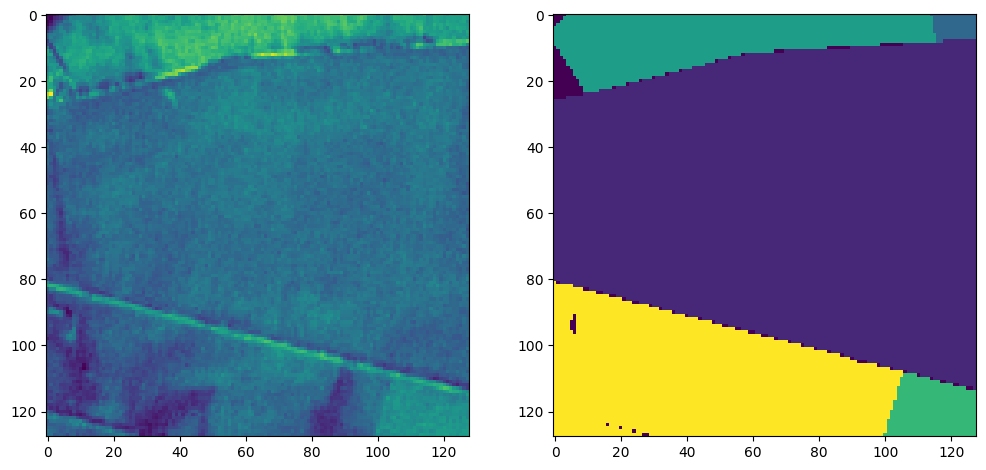

In [ ]:
import matplotlib.pyplot as plt
print(indexes[0])
batch_sample = train_seq[0][0]

smp_idx = 15
img_sample = batch_sample[smp_idx]
mask_sample = train_seq[0][1][smp_idx]

print(len(train_seq))
print(img_sample.shape)
print(mask_sample.shape)


figure, axarr = plt.subplots(1, 2)
figure.set_size_inches((12,12))

axarr[0].imshow(img_sample[..., 0])
axarr[1].imshow(np.argmax(mask_sample,axis=-1))

plt.show()

# Model definition

In [ ]:
!pip install keras-unet-collection==0.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: keras-unet-collection
    Found existing installation: keras-unet-collection 0.1.13
    Uninstalling keras-unet-collection-0.1.13:
      Successfully uninstalled keras-unet-collection-0.1.13


In [ ]:
from keras_unet_collection.models import swin_unet_2d

filter_num_begin = 128     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 4                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_down = 2        # number of Swin Transformers per downsampling level
stack_num_up = 2           # number of Swin Transformers per upsampling level
patch_size = (4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 512              # number of MLP nodes within the Transformer
shift_window=True

model = swin_unet_2d(
  input_size = img_sample.shape,
  filter_num_begin = filter_num_begin,
  n_labels = len(CLASSES) + 1,
  depth=depth,
  stack_num_down = stack_num_down,
  stack_num_up = stack_num_up,
  patch_size = patch_size,
  num_heads = num_heads,
  window_size = window_size,
  num_mlp = num_mlp,
  output_activation = 'Softmax',
)
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 patch_extract_16 (patch_extrac  (None, 1024, 48)    0           ['input_17[0][0]']               
 t)                                                                                               
                                                                                                  
 patch_embedding_16 (patch_embe  (None, 1024, 128)   137344      ['patch_extract_16[0][0]']       
 dding)                                                                             

In [ ]:
optim = keras.optimizers.Adam(learning_rate=1e-4, clipvalue=0.5)
model.compile(
    optimizer=optim, 
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.13),
     metrics=[
        'categorical_accuracy',
    ]
)

In [ ]:
N_epoch = 20 # number of epoches
N_batch = 800 # number of batches per epoch

tol = 0 # current early stopping patience/toralance
max_tol = 3 # the max-allowed early stopping patience/toralance
min_del = 0 # the lowest acceptable loss value reduction 

for epoch in range(N_epoch):
    train_seq.on_epoch_end()
    # initial loss record
    if epoch == 0:
        valid_input, valid_target = val_seq[0]
        y_pred = model.predict([valid_input,])
        record = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        
        # batch data formation
        ## augmentation is not applied
        train_input, train_target = train_seq[step]
        
        # train on batch
        loss_ = model.train_on_batch(train_input, train_target)
#         if np.isnan(loss_):
#             print("Training blow-up")

        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict(valid_input)
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        model.save(f'/content/drive/MyDrive/dimploma/swinunet_test/swinunet_val_{record_temp}.h5')
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

1/1 [==============================] - 5s 5s/step
	Initial loss = 3.7671878337860107
1/1 [==============================] - 0s 96ms/step
Validation performance is improved from 3.7671878337860107 to 1.60598623752594
1/1 [==============================] - 0s 94ms/step
Validation performance is improved from 1.60598623752594 to 1.4319934844970703
1/1 [==============================] - 0s 97ms/step
Validation performance is improved from 1.4319934844970703 to 1.218626618385315
1/1 [==============================] - 0s 105ms/step
Validation performance is improved from 1.218626618385315 to 0.8982294797897339
1/1 [==============================] - 0s 95ms/step
Validation performance is improved from 0.8982294797897339 to 0.7307604551315308
1/1 [==============================] - 0s 93ms/step
Validation performance is improved from 0.7307604551315308 to 0.619476854801178
1/1 [==============================] - 0s 120ms/step
Validation performance is improved from 0.619476854801178 to 0.5709571

KeyboardInterrupt: ignored

# Results

In [ ]:
from sklearn.metrics import classification_report

model.load_weights("/content/drive/MyDrive/dimploma/swinunet_test/swinunet_val_0.48412004113197327.h5")

preds = np.array([])
test_labels = np.array([])
for i in range(len(val_seq) // 4):
    x_test, y_test = val_seq[i]
    prediction = np.argmax(model.predict(x_test[..., :10]), axis=-1).flatten()
    preds = np.append(preds, prediction)
    label =  np.argmax(y_test[..., :10], axis=-1).flatten()
    test_labels = np.append(test_labels, label)

1/1 [==============================] - 0s 122ms/step


In [ ]:
print(classification_report(test_labels, preds, target_names = ['Nothing']+CLASSES[:9]))

              precision    recall  f1-score   support

     Nothing       0.94      0.96      0.95  11701033
       Wheat       0.90      0.92      0.91   2509637
         Rye       0.91      0.90      0.90   2014446
      Barley       0.92      0.89      0.90   1306197
        Oats       0.94      0.85      0.89    173872
        Corn       0.92      0.88      0.90   2134317
   Oil Seeds       0.92      0.91      0.91   2039977
  Root Crops       0.93      0.80      0.86     34805
     Meadows       0.88      0.81      0.85   1066996
Forage Crops       0.92      0.85      0.88    873824

    accuracy                           0.92  23855104
   macro avg       0.92      0.88      0.90  23855104
weighted avg       0.92      0.92      0.92  23855104

